## **predict weather with MLP**

In [1]:
!pip install wandb

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import wandb
from wandb.keras import WandbCallback

## Read Data

In [3]:
data = pd.read_csv("data/weatherHistory.csv")

In [4]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Preprocess Data

In [5]:
data['DateTime'] = pd.to_datetime(data['Formatted Date'], utc=True)

In [6]:
data['Year'] = data['DateTime'].dt.year

In [7]:
data['DoY'] = data['DateTime'].dt.dayofyear

In [8]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,DateTime,Year,DoY
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00,2006,90
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00,2006,90
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00,2006,91
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00,2006,91
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00,2006,91


In [9]:
Average_Temperature = data.groupby(['DoY', 'Year'])['Temperature (C)'].mean().reset_index()
Average_Temperature.rename(columns= {'Temperature (C)' : 'Avg_Temperature'}, inplace = True)
Average_Temperature
# Humidity = data.groupby(['DoY', 'Year'])['Humidity'].mean().reset_index()
# Wind Speed (km/h) = data.groupby(['DoY', 'Year'])['Wind Speed (km/h)'].mean().reset_index()
# Wind Bearing (degrees) = data.groupby(['DoY', 'Year'])['Wind Bearing (degrees)'].mean().reset_index()
# Visibility (km) = data.groupby(['DoY', 'Year'])['Visibility (km)'].mean().reset_index()
# Pressure (millibars) = data.groupby(['DoY', 'Year'])['Pressure (millibars)'].mean().reset_index()



,DoY,Year,Avg_Temperature
0,1,2006,4.075000
1,1,2007,3.806713
2,1,2008,-5.663194
3,1,2009,-4.850926
4,1,2010,7.807407
...,...,...,...
4014,365,2015,-4.304861
4015,365,2016,0.117593
4016,366,2008,-6.218056
4017,366,2012,-3.249306


In [10]:
X_data = Average_Temperature['DoY'].to_numpy()
X_data = X_data.reshape(-1, 1)
Y_data = Average_Temperature['Avg_Temperature'].to_numpy()
Y_data = Y_data.reshape(-1, 1)

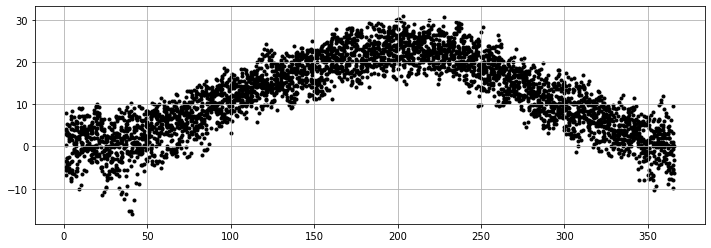

In [11]:
plt.figure(figsize=(12,4))
plt.grid()
plt.scatter(Average_Temperature['DoY'], Average_Temperature['Avg_Temperature'], marker='.', c='k')
plt.show()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, shuffle=True)

In [13]:
wandb.init(project= "predict weather")

wandb: Currently logged in as: fereshteh_ebadi (use `wandb login --relogin` to force relogin)


In [14]:
config = wandb.config
config.learning_rate = 0.01

## Config Model

In [15]:
model = tf.keras.models.Sequential([
        Dense(128, input_dim= 1, activation= "relu"),
        Dense(64, activation= "relu"),
        Dense(32, activation= "relu"),
        Dense(16, activation= "relu"),
        Dense(1, activation= "linear")
])

In [16]:
model.compile(tf.keras.optimizers.Adam(learning_rate= config.learning_rate), 
              loss = tf.keras.losses.MeanAbsoluteError())

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________


## Train

In [18]:
model.fit(X_train, Y_train, epochs= 300, callbacks=[WandbCallback()])

Epoch 1/300
95/95 [==============================] - 1s 2ms/step - loss: 8.7635 - _timestamp: 1646596732.0000 - _runtime: 7.0000
Epoch 2/300
95/95 [==============================] - 0s 2ms/step - loss: 8.1318 - _timestamp: 1646596732.0000 - _runtime: 7.0000
Epoch 3/300
95/95 [==============================] - 0s 2ms/step - loss: 7.8859 - _timestamp: 1646596732.0000 - _runtime: 7.0000
Epoch 4/300
95/95 [==============================] - 0s 2ms/step - loss: 7.7884 - _timestamp: 1646596733.0000 - _runtime: 8.0000
Epoch 5/300
95/95 [==============================] - 0s 3ms/step - loss: 7.5833 - _timestamp: 1646596733.0000 - _runtime: 8.0000
Epoch 6/300
95/95 [==============================] - 0s 2ms/step - loss: 7.3647 - _timestamp: 1646596733.0000 - _runtime: 8.0000
Epoch 7/300
95/95 [==============================] - 0s 2ms/step - loss: 7.4785 - _timestamp: 1646596733.0000 - _runtime: 8.0000
Epoch 8/300
95/95 [==============================] - 0s 2ms/step - loss: 5.7804 - _timestamp: 164

In [19]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 2.9895


2.989492416381836

## Inference

In [20]:
result = model.predict([150])
result

array([[18.45373]], dtype=float32)

## plot

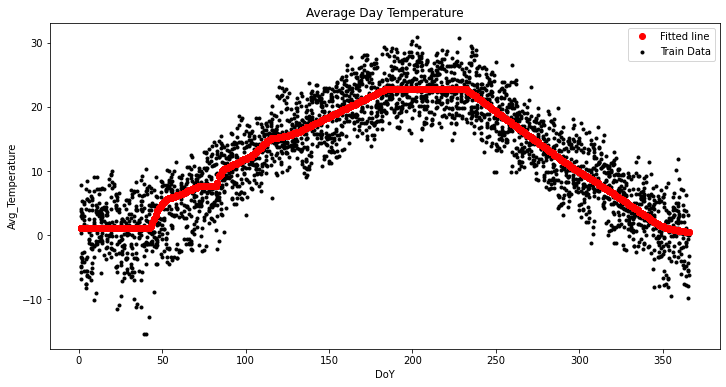

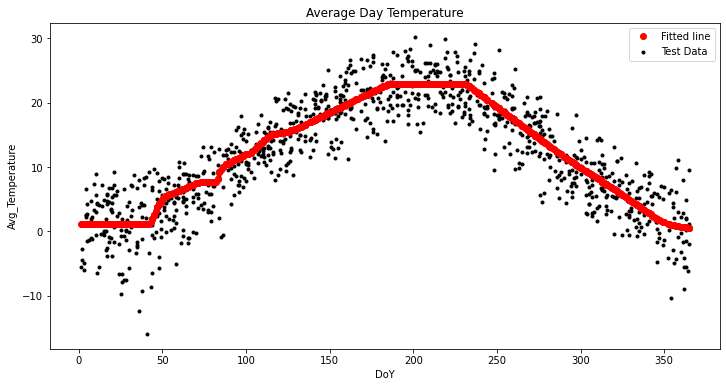

In [21]:
Y_pred = model.predict(X_train)

plt.figure(figsize=(12, 6))
plt.scatter(X_train, Y_train, marker='.', c='k', label='Train Data')
plt.plot(X_train, Y_pred, 'o' , color='red',  label='Fitted line')
plt.xlabel('DoY')
plt.ylabel('Avg_Temperature')
plt.title('Average Day Temperature')
plt.legend()
plt.show()

Y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.scatter(X_test, Y_test, marker='.', c='k', label='Test Data')
plt.plot(X_test, Y_pred, 'o' , color='red',  label='Fitted line')
plt.xlabel('DoY')
plt.ylabel('Avg_Temperature')
plt.title('Average Day Temperature')
plt.legend()
plt.show()
